112
./data/textures/Normalized Brodatz/D19.tif
(640, 640, 3)
(640, 640, 3)


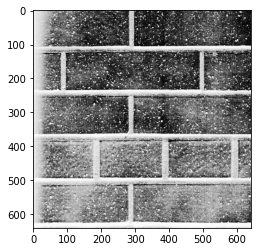

In [48]:
# Needed for the actual stuff
%matplotlib inline 
from glob import glob
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
from data import plot_multiple_images

extension = '.tif'

# Just to visualise


folder_path = './data/textures/Normalized Brodatz'
imgs = glob(os.path.join(folder_path,'*'+extension))

print(len(imgs))
print(imgs[0])

img0 = cv2.imread(imgs[0])
img1 = cv2.imread(imgs[1])
img2 = cv2.imread(imgs[2], cv2.COLOR_BGR2GRAY) # NOTE: this is to support using the cmaps, cmaps only work in 1D not 3D


plt.imshow(img1)

print(img1.shape)
b,g,r = cv2.split(img1)

np.multiply(b, 1.25, out=b, casting="unsafe")
np.multiply(g, .75, out=g, casting="unsafe")
np.multiply(r, 1.5, out=r, casting="unsafe")

after = cv2.merge([b, g, r])

w,h,c = after.shape
print(after.shape)


# plt.imshow(after)


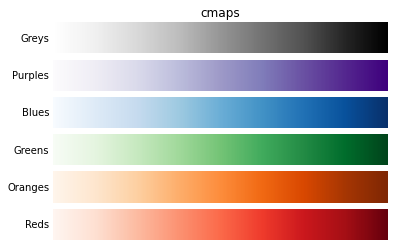

In [49]:
# Demonstrate colour map for the full spectrum of values (all coming from grayscale)
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds']

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

nrows = len(cmaps)
fig, axs = plt.subplots(nrows=nrows)
axs[0].set_title('cmaps')
for ax, cmap in zip (axs, cmaps):
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.text(-.01, .5, cmap, va='center', ha='right', fontsize=10, transform=ax.transAxes)

for ax in axs:
    ax.set_axis_off()

plt.show()


In [50]:
# # Showing the effect on the texture sample

# # print(img2.shape)

# # fig, axs = plt.subplots(nrows=nrows)
# # axs[0].set_title('cmaps')
# try:
#     os.mkdir('test')
#     for cmap in cmaps:
#         for i, img in enumerate(imgs):
#             img = cv2.imread(img, cv2.COLOR_BGR2GRAY)
#             plt.imsave('test/test'+cmap+str(i)+'.png', img, cmap=cmap)
# except OSError as error:
#     print(error)

#     # for ax, cmap in zip (axs, cmaps):
#         # ax.imshow(img, cmap=cmap)
#         # ax.text(-.01, .5, cmap, va='center', ha='right', fontsize=10, transform=ax.transAxes)

# # for ax in axs:
# #     ax.set_axis_off()

# # plt.show()


In [51]:
# percents = [0, 0.25,0.5,0.75,1]
# percents = np.vstack(percents)
# # gradient = np.multiply(percents,255)
# print(gradient)

# fig = plt.figure(figsize=(1,len(cmaps)))
# fig.set_size_inches(5,5)

# # axs[0].set_title('cmaps')
# for i, cmap in enumerate(cmaps):
#     fig.add_subplot(1,len(cmaps), i+1)
#     ax.imshow(Image.fromarray(np.uint8(percents*255),'L'), cmap=cmap)
# plt.show()

In [52]:
# dictTest = dict()
# percents = [0, 0.25,0.5,0.75,1]
# for cmap in cmaps:
#     cmap_test = plt.cm.get_cmap(cmap)
#     dictTest[cmap] = [cmap_test(i) for i in percents] # cmap_test outputs rgba

# testImg = np.array(dictTest['Reds'], np.uint8)[:,None,:]
# print(testImg.shape)
# print(testImg)
# plt.imshow(testImg, interpolation='nearest')

(40, 40)
[(0, 0), (19, 32), (56, 69), (68, 99), (91, 99), (99, 99)]


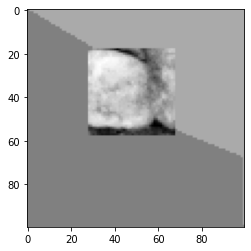

In [319]:
import random
from PIL import Image

random_cmap = random.choice(cmaps)
cmap_test = plt.cm.get_cmap(random_cmap)

random_image = cv2.imread(random.choice(imgs), cv2.COLOR_BGR2GRAY)
max_x, max_y = random_image.shape 

w,h = 40,40 
img_size = (100,100)

x,y = random.randint(0, max_x-w), random.randint(0, max_y-h)
crop = random_image[y:y+h, x:x+w] # crops the image into a w,h portion
print(crop.shape)

x,y = 0,0
coords = [(0,0)] # TODO: make it loop over the list itself instead? not neccessary
while x < img_size[0]-1 or y < img_size[1]-1:
    x = min(x + random.randint(10,40), img_size[0]-1)
    y = min(y + random.randint(10,40), img_size[1]-1)
    coords.append((x,y))
print(coords)

new_x, new_y = random.randint(0, img_size[0]-(w*1.5)), random.randint(0, img_size[1]-(h*1.5))
new_image = np.zeros(img_size, np.uint8)


def bresenhams(array,x1,y1,x2,y2, fill_value=255):
  # from https://github.com/encukou/bresenham/blob/master/bresenham.py
  dx = x2 - x1
  dy = y2 - y1

  xsign = 1 if dx > 0 else -1
  ysign = 1 if dy > 0 else -1

  dx = abs(dx)
  dy = abs(dy)

  if dx > dy:
      xx, xy, yx, yy = xsign, 0, 0, ysign
  else:
      dx, dy = dy, dx
      xx, xy, yx, yy = 0, ysign, xsign, 0

  D = 2*dy - dx
  y = 0

  
  for x in range(dx + 1):
      a,b = x1 + x*xx + y*yx, y1 + x*xy + y*yy

      array[:a,b] = value
      array[a:,b] = 255-value

      if D >= 0:
          y += 1
          D -= 2*dx
      D += 2*dy

value = random.randint(40,255)
for c1, c2 in zip(coords, coords[1:]):
  # draw a line between each of the randomly generated coordinates
  bresenhams(new_image,*c1,*c2, fill_value=value)

plt.imshow(Image.fromarray(new_image), cmap='Greys')

# from https://stackoverflow.com/a/50692782
def paste_slices(tup):
  pos, w, max_w = tup
  wall_min = max(pos, 0)
  wall_max = min(pos+w, max_w)
  block_min = -min(pos, 0)
  block_max = max_w-max(pos+w, max_w)
  block_max = block_max if block_max != 0 else None
  return slice(wall_min, wall_max), slice(block_min, block_max)

def paste(wall, block, loc):
  loc_zip = zip(loc, block.shape, wall.shape)
  wall_slices, block_slices = zip(*map(paste_slices, loc_zip))
  wall[wall_slices] = block[block_slices]

paste(new_image, crop, (new_x, new_y)) # put the crop into the image, TODO: do this after drawing the line?

# TODO: combine things to cmap on different layer images??
# TODO: add the constant +40 or a -40 to the ligher / darker sides of the pasted texture? and max/min it obv

plt.imshow(Image.fromarray(new_image), cmap='Greys')
